In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from regressors import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import time
sns.set()

In [296]:
''' load and view the data. '''
data = pd.read_csv("../csv/suicide.csv", index_col = 0)
data

,country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,continent
1,Albania,1987,Male,15-24,21,312900.0,2.156625e+09,796,Generation X,Europe
2,Albania,1987,Male,35-54,16,308000.0,2.156625e+09,796,Silent,Europe
3,Albania,1987,Female,15-24,14,289700.0,2.156625e+09,796,Generation X,Europe
4,Albania,1987,Male,75+,1,21800.0,2.156625e+09,796,G.I. Generation,Europe
5,Albania,1987,Male,25-34,9,274300.0,2.156625e+09,796,Boomers,Europe
...,...,...,...,...,...,...,...,...,...,...
27656,Uzbekistan,2014,Female,35-54,107,3620833.0,6.306708e+10,2309,Generation X,Asia
27657,Uzbekistan,2014,Female,75+,9,348465.0,6.306708e+10,2309,Silent,Asia
27658,Uzbekistan,2014,Male,5-14,60,2762158.0,6.306708e+10,2309,Generation Z,Asia
27659,Uzbekistan,2014,Female,5-14,44,2631600.0,6.306708e+10,2309,Generation Z,Asia


We create a regression model predicting the number of suicides. We also tried creating a model that predicts the suicide rate directly. The model was worse. We hypothesize this as the result of the regression variable being a combination of two different variables thats nonlinear, therefore harder to model. The suicide rate can be also calculated from the predicted number of suicides.

# preprocessing the data
As variables need to be numerical, we create dummy variables for the categorical variables. For the age variable we create 
a mapping from 1 to 5, as the value is ordinal and can be compared. Besides, we drop the generation variable, since as mentioned earlier, the variable is determined by the year and age group, adding no additional information.

In [297]:
age_map = {"5-14" : 1,
           "15-24" : 2,
           "25-34" : 3,
           "35-54" : 4,
           "55-74" : 5,
           "75+" : 6}
data["age"] = data["age"].apply(lambda age_group: age_map[age_group])
data

,country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,continent
1,Albania,1987,Male,2,21,312900.0,2.156625e+09,796,Generation X,Europe
2,Albania,1987,Male,4,16,308000.0,2.156625e+09,796,Silent,Europe
3,Albania,1987,Female,2,14,289700.0,2.156625e+09,796,Generation X,Europe
4,Albania,1987,Male,6,1,21800.0,2.156625e+09,796,G.I. Generation,Europe
5,Albania,1987,Male,3,9,274300.0,2.156625e+09,796,Boomers,Europe
...,...,...,...,...,...,...,...,...,...,...
27656,Uzbekistan,2014,Female,4,107,3620833.0,6.306708e+10,2309,Generation X,Asia
27657,Uzbekistan,2014,Female,6,9,348465.0,6.306708e+10,2309,Silent,Asia
27658,Uzbekistan,2014,Male,1,60,2762158.0,6.306708e+10,2309,Generation Z,Asia
27659,Uzbekistan,2014,Female,1,44,2631600.0,6.306708e+10,2309,Generation Z,Asia


In [299]:
def encode_dummy_data(df, cat_fts, other_fts):
    encoded = pd.get_dummies(df[cat_fts])
    cat_fts_encoded = encoded.columns.values.tolist()
    df = pd.concat([df[other_fts], encoded], axis=1, sort=False)
    return df[other_fts + cat_fts_encoded]

continuous_features = ["year", "population", "gdp_for_year", "gdp_per_capita", "suicides_no"] # not updated
ordinal_features = ["age"]
dont_use_features = ["generation"]
categorical_features = list(set(data.columns) - set(continuous_features) - set(ordinal_features) - set(dont_use_features))

dummied_data = encode_dummy_data(data, categorical_features, continuous_features + ordinal_features)
dummied_data

,year,population,gdp_for_year,gdp_per_capita,suicides_no,age,country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,...,country_United States,country_Uruguay,country_Uzbekistan,sex_Female,sex_Male,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
1,1987,312900.0,2.156625e+09,796,21,2,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1987,308000.0,2.156625e+09,796,16,4,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1987,289700.0,2.156625e+09,796,14,2,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1987,21800.0,2.156625e+09,796,1,6,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,1987,274300.0,2.156625e+09,796,9,3,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27656,2014,3620833.0,6.306708e+10,2309,107,4,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
27657,2014,348465.0,6.306708e+10,2309,9,6,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
27658,2014,2762158.0,6.306708e+10,2309,60,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
27659,2014,2631600.0,6.306708e+10,2309,44,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


From our 27660, we remove the data that could make our model significantly worse for most of the incoming data. After removing, we have 26315 data left. We remove the top 1 percentile data with the highest suicide number, bottom and top 1 percentile of gpd_for_year and gpd_per_capita. These percentiles were chosen experimentally based on the R^2 score.

In [300]:
filtered_dummied_data = dummied_data[
    dummied_data["gdp_for_year"].between(
        np.percentile(dummied_data["gdp_for_year"], 1),
        np.percentile(dummied_data["gdp_for_year"], 99)
    )]
filtered_dummied_data = filtered_dummied_data[
    filtered_dummied_data["gdp_per_capita"].between(
        np.percentile(filtered_dummied_data["gdp_per_capita"], 1),
        np.percentile(filtered_dummied_data["gdp_per_capita"], 99)
    )]
filtered_dummied_data = filtered_dummied_data[
    filtered_dummied_data["suicides_no"].between(
        np.percentile(filtered_dummied_data["suicides_no"], 0),
        np.percentile(filtered_dummied_data["suicides_no"], 99)
    )]
filtered_dummied_data

,year,population,gdp_for_year,gdp_per_capita,suicides_no,age,country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,...,country_United States,country_Uruguay,country_Uzbekistan,sex_Female,sex_Male,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
1,1987,312900.0,2.156625e+09,796,21,2,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1987,308000.0,2.156625e+09,796,16,4,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1987,289700.0,2.156625e+09,796,14,2,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1987,21800.0,2.156625e+09,796,1,6,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,1987,274300.0,2.156625e+09,796,9,3,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27656,2014,3620833.0,6.306708e+10,2309,107,4,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
27657,2014,348465.0,6.306708e+10,2309,9,6,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
27658,2014,2762158.0,6.306708e+10,2309,60,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
27659,2014,2631600.0,6.306708e+10,2309,44,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


In [301]:
'''By removing 1 top percentile from the number of suicides, the variability decreased immensely. from a maximum of 20k suicides in a group, 
we put it down to about 3000. As a result the model will have an easier time modeling that. We keep an unfiltered dataset for later comparison of 
the different models as the linear models will have an easier time with less variability.'''
filtered_dummied_data["suicides_no"].describe()

count    26315.000000
mean       158.098803
std        366.671908
min          0.000000
25%          3.000000
50%         24.000000
75%        123.000000
max       3133.000000
Name: suicides_no, dtype: float64

# split our model into train/test data
We split our data into training and testing while also creating a data scaler. For the simple linear models this does not create a difference but for other models this may create a difference. We use the MinMaxScaler as the simplest scaling method.

In [302]:
'''not filtered data'''
y_nf = dummied_data.loc[:, 'suicides_no']
X_nf = dummied_data.drop(['suicides_no'], axis=1)
features = X.columns.values

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(X_nf, y_nf, test_size=0.25, random_state=42)

In [303]:
'''filtered data'''
y = filtered_dummied_data.loc[:, 'suicides_no']
X = filtered_dummied_data.drop(['suicides_no'], axis=1)
features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [304]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

scaler_nf = MinMaxScaler()
scaler_nf.fit(X_train_nf)
X_train_nf = pd.DataFrame(scaler.transform(X_train_nf), columns=features)
X_test_nf = pd.DataFrame(scaler.transform(X_test_nf), columns=features)

In [160]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE for the Linear regression model: {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("R^2 train: {}, R^2 test: {}".format(model.score(X_train, y_train), model.score(X_test, y_test)))

RMSE for the Linear regression model: 230.60916652570077
R^2 train: 0.6128974094794184, R^2 test: 0.6124790835885768


A RMSE of 230 means that on average we have a 230 residual. As the mean of the number of suicides is 165, that is not very satisfying, although we are still less than one standard deviation. The R^2 score is not as bad though. Note that we are calculating the R^2 score from the data EXCLUDING the outliers we removed.

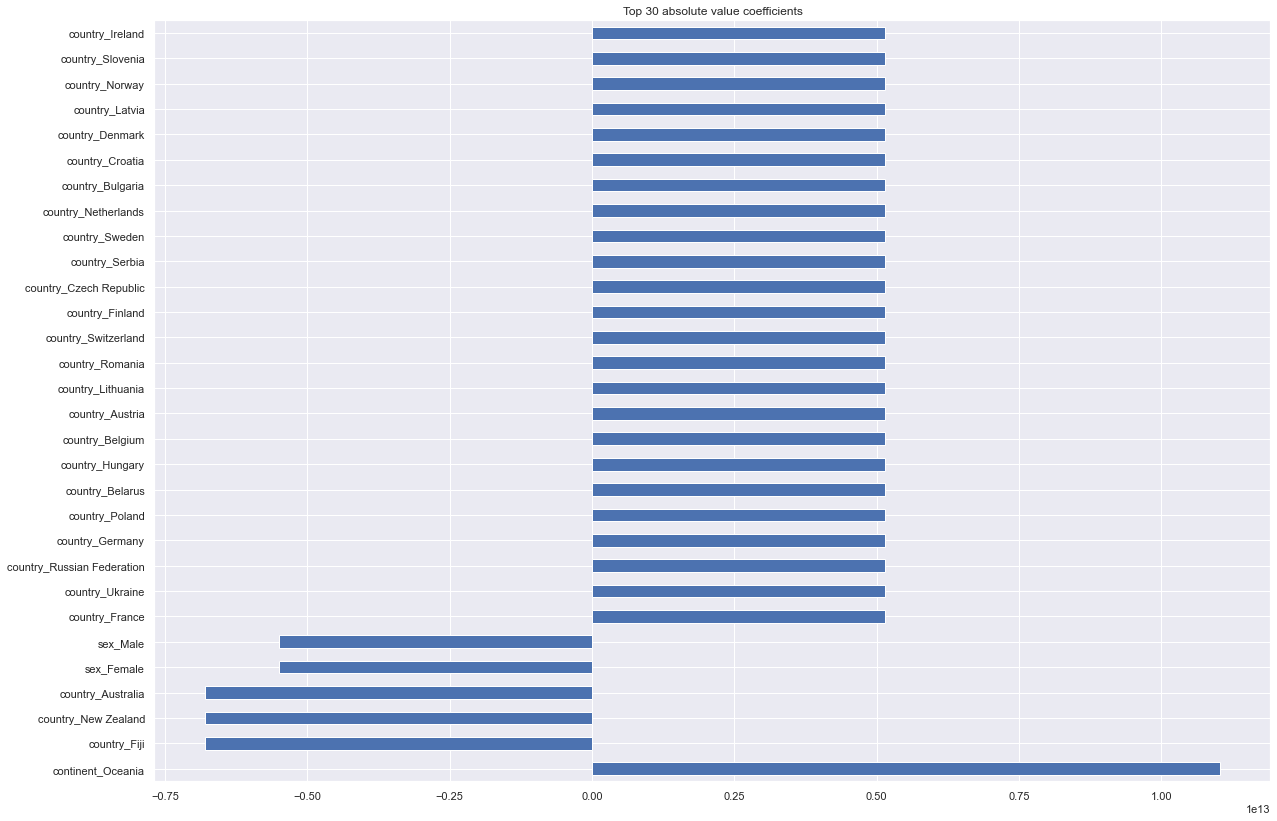

In [161]:
def plot_top_feats(n, coefs, index):
    dc = pd.Series(coefs, index=index)
    top_n_keys = abs(dc).nlargest(n).keys()
    plt.title("Top {} absolute value coefficients".format(n))
    dc[top_n_keys].plot(kind='barh', figsize=(20,14))

plot_top_feats(30, model.coef_, features)

All the coefficients have a high absolute value. The highest coefficients are in categorical variables. This in fact could mean that it categorizes our regression value. No numeric values are to be found here. This is without regularization. We now try Lasso and then ElasticNet.

In [162]:
model = linear_model.LassoCV(cv=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE for the Linear regression model: {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("R^2 train: {}, R^2 test: {}".format(model.score(X_train, y_train), model.score(X_test, y_test)))
print("Alpha used: {}".format(model.alpha_))

RMSE for the Linear regression model: 230.58652804539105
R^2 train: 0.612792156426003, R^2 test: 0.6125551642939444
Alpha used: 0.03069385887715671


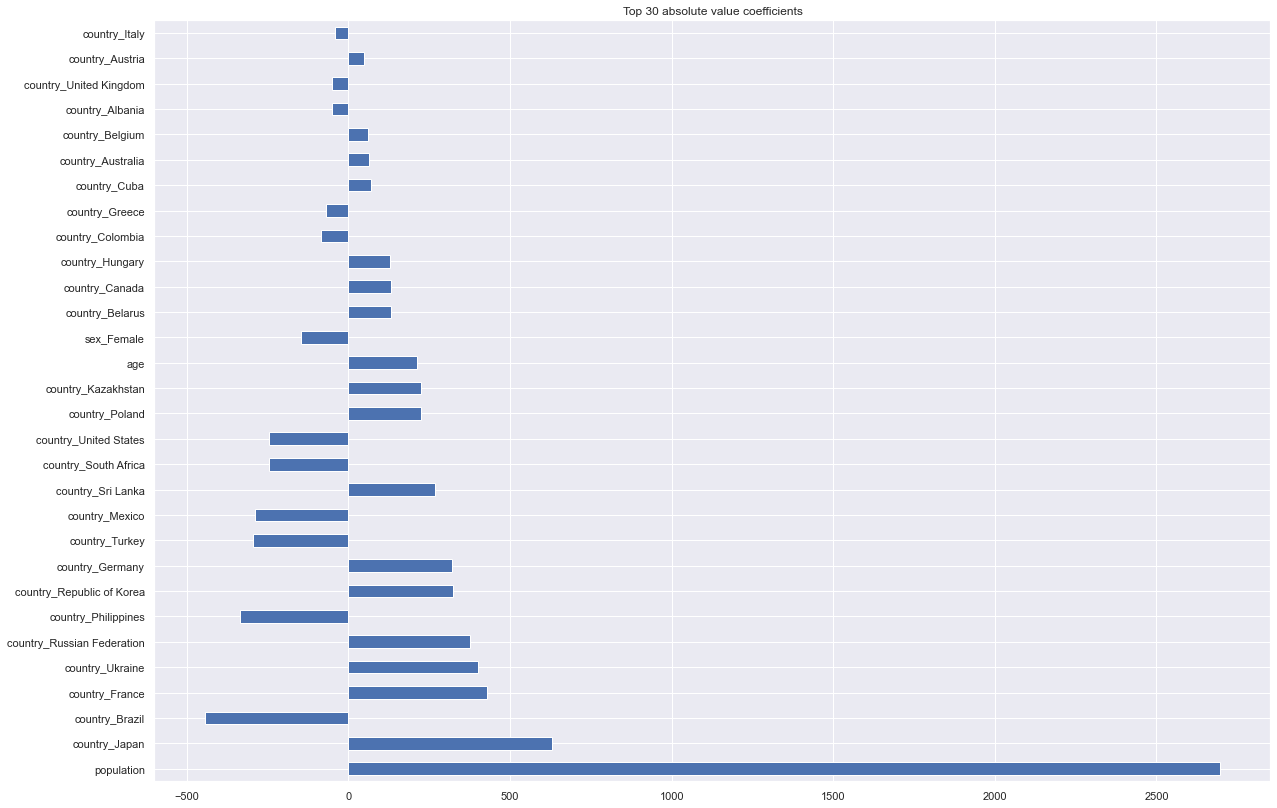

In [163]:
plot_top_feats(30, model.coef_, features)

Lasso regulates the coefficients greatly, and gives the population coefficient the highest value. Lasso as opposed to standard OLS has pretty much the same R^2 and RMSE.  

In [164]:
model = linear_model.ElasticNetCV(cv=10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE for the Linear regression model: {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("R^2 train: {}, R^2 test: {}".format(model.score(X_train, y_train), model.score(X_test, y_test)))
print("Alpha used: {}".format(model.alpha_))
print("l1_ratio used: {}".format(model.l1_ratio_))

RMSE for the Linear regression model: 230.58652804539105
R^2 train: 0.612792156426003, R^2 test: 0.6125551642939444
Alpha used: 0.03069385887715671
l1_ratio used: 1.0


Elastic Net chooses the L1_ratio as 1.0 therefore it doesn't differ from the Lasso model. 
Let's now try a non linear model - we try a polynomial fit of degree 2, as for our 120~ variables, the amount of variables created after the polynomial transformation is about 6400.

# Non linear model

In [165]:
'''We transform our data and then use the linear regression.'''
poly = PolynomialFeatures(degree=2)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.transform(X_test)

In [167]:
start = time.time()
model = linear_model.LinearRegression()
model.fit(poly_X_train, y_train)
print("runtime of training: {} seconds".format(time.time() - start))
start = time.time()
y_pred = model.predict(poly_X_test)
print("runtime of prediction: {} seconds".format(time.time() - start))
print("RMSE for the Linear regression model: {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("R^2 train: {}, R^2 test: {}".format(model.score(poly_X_train, y_train), model.score(poly_X_test, y_test)))

runtime of training: 189.0465567111969 seconds
runtime of prediction: 0.5120141506195068 seconds
RMSE for the Linear regression model: 121.0169176078606
R^2 train: 0.8992373079146638, R^2 test: 0.8932828569713456


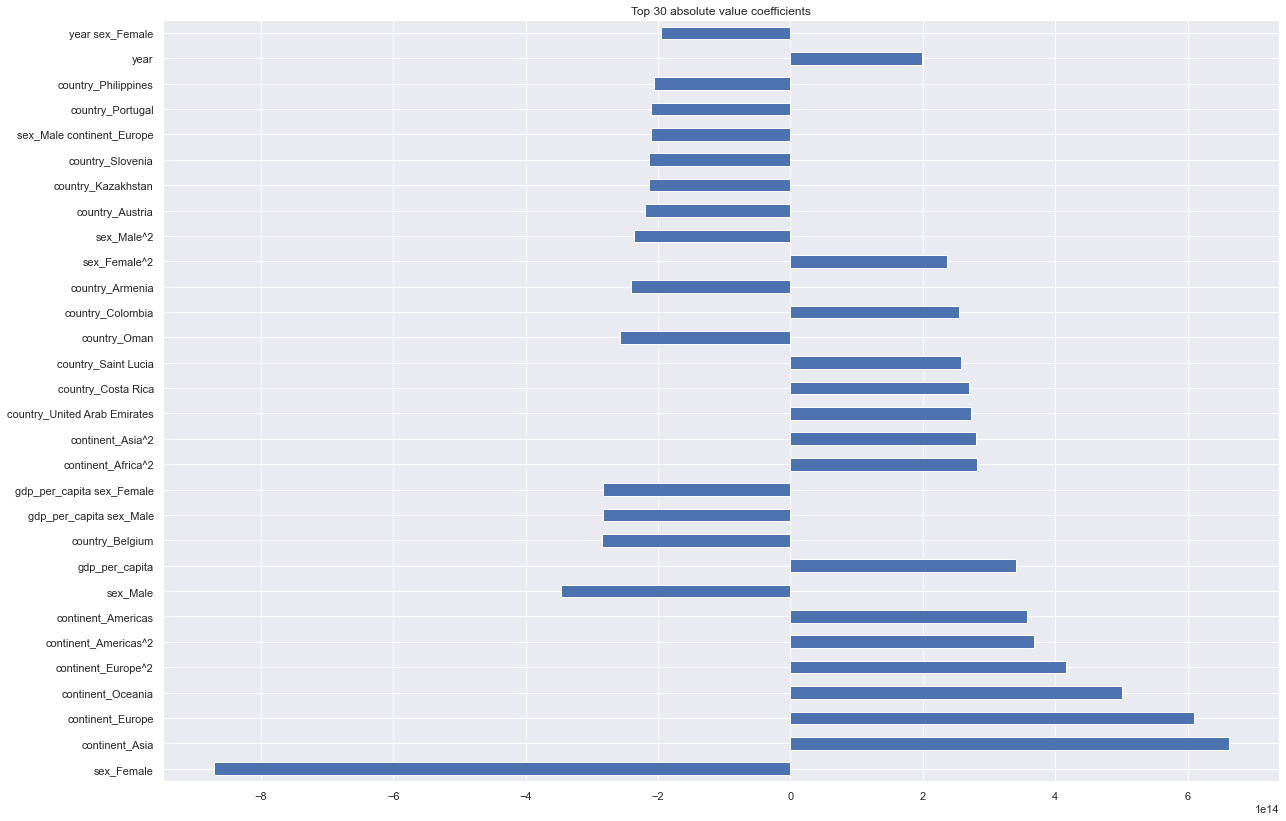

In [168]:
plot_top_feats(30, model.coef_, poly.get_feature_names(features))

Using polynomial features gets us R^2 score to 0.89 which is pretty good. The RMSE is 124, almost twice as good as Lasso. The training takes a bit over 3 minutes on my computer (dell xps 13 model 9350) which is not that much and the prediction time is still good. Here, the highest coefficients are the original ones. The coefficients are super high though. This also suggest trying out kernel methods with a polynomial kernel.

In [169]:
print("number of variables: {}".format(len(model.coef_)))

number of variables: 6441


We try training the polynomial features on the Lasso model, and find out what variables have the highest weight.

In [170]:
start = time.time()
model = linear_model.LassoCV(cv=10)
model.fit(poly_X_train, y_train)
print("runtime of training: {} seconds".format(time.time() - start))
start = time.time()
y_pred = model.predict(poly_X_test)
print("runtime of prediction: {} seconds".format(time.time() - start))
print("RMSE for the Linear regression model: {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("R^2 train: {}, R^2 test: {}".format(model.score(poly_X_train, y_train), model.score(poly_X_test, y_test)))
print("Alpha used: {}".format(model.alpha_))

runtime of training: 522.8681602478027 seconds
runtime of prediction: 0.5049998760223389 seconds
RMSE for the Linear regression model: 128.18522980955007
R^2 train: 0.8840165133451807, R^2 test: 0.8802658628570732
Alpha used: 0.02862519551759758


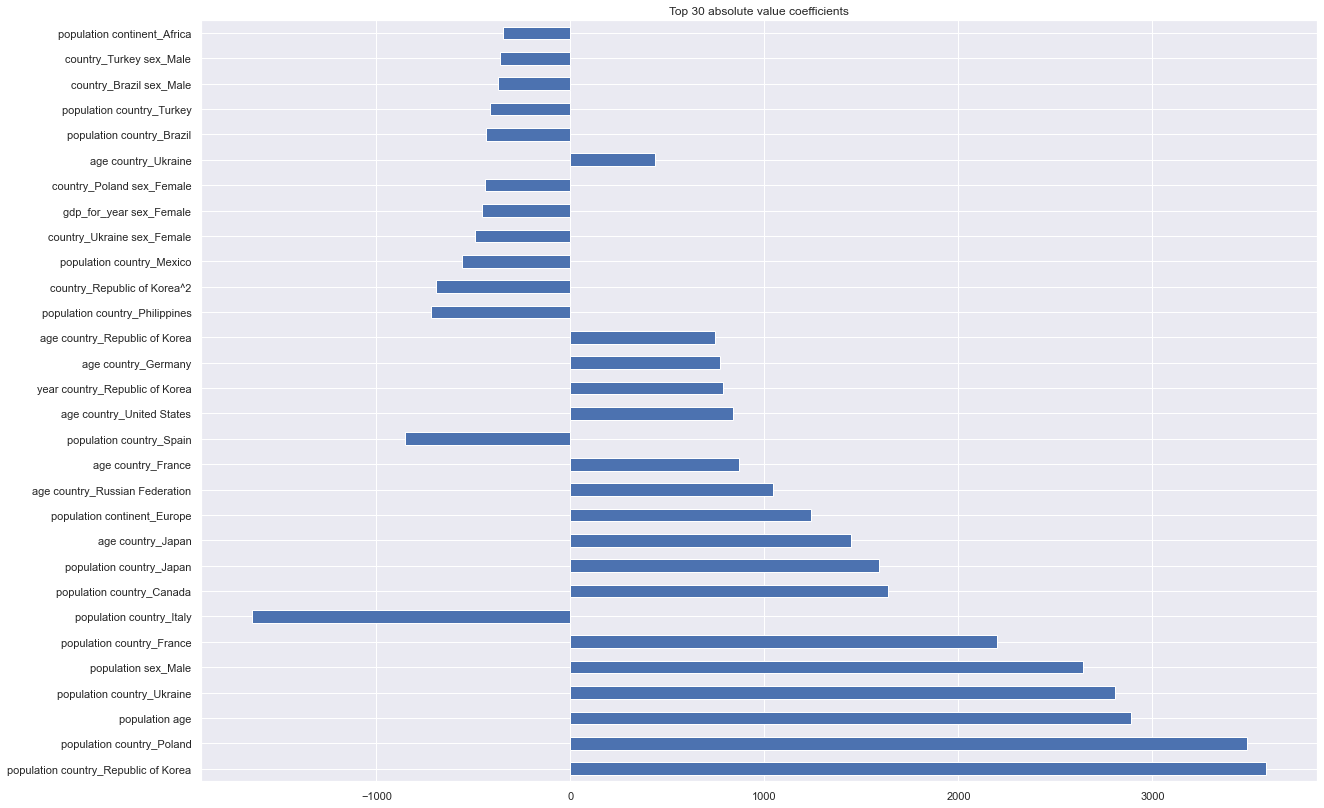

In [173]:
plot_top_feats(30, model.coef_, poly.get_feature_names(features))

In [174]:
np.sum(model.coef_ < 1)

6305

Although the Lasso model is a bit worse - 0.88 R^2, 128 RMSE, we can see the regularized coefficients. In this model, the features with the highest coefficients are all combinations. We can see that by simply removing variables with coefficients less than 1, we remove 6305 variables, creating a model of about 150~ variables.

# Different, not very interpretable models
We try different models for filtered and unfiltered data. The parameters for the model were chosen experimentally.

In [307]:
def train_model_cv(m, X_tr, y_tr, X_ts, y_ts):
    m = model
    print("mean 5 fold cross validated R^2 score: {}".format(cross_val_score(model, X_tr, y_tr, cv=5).mean()))
    start = time.time()
    model.fit(X_tr, y_tr)
    print("runtime of training without CV: {} seconds".format(time.time() - start))
    start = time.time()
    y_pred_test = model.predict(X_ts)
    print("runtime of prediction: {} seconds".format(time.time() - start))
    print("RMSE test set: {}".format(mean_squared_error(y_ts, y_pred_test, squared=False)))
    print("R^2 test: {}".format(r2_score(y_ts, y_pred_test)))
    return m

## Extra trees regression

In [278]:
'''filtered data'''
model = ExtraTreesRegressor(n_estimators=500, max_depth=4)
model = train_model_cv(model, X_train, y_train, X_test, y_test)

mean 5 fold cross validated R^2 score: 0.6490566381856391
runtime of training without CV: 30.04732036590576 seconds
runtime of prediction: 0.1690351963043213 seconds
RMSE for the Extra trees model on the test set: 216.54662505542044
R^2 test: 0.6583000972486515


In [279]:
'''unfiltered data'''
model = ExtraTreesRegressor(n_estimators=500, max_depth=4)
model = train_model_cv(model, X_train_nf, y_train_nf, X_test_nf, y_test_nf)

mean 5 fold cross validated R^2 score: 0.8096314407301273
runtime of training without CV: 37.25484490394592 seconds
runtime of prediction: 0.17499923706054688 seconds
RMSE for the Extra trees model on the test set: 414.8746231961938
R^2 test: 0.7733476310017302


Extra trees for unfiltered data are worse than the polynomial regression. For the unfiltered part, it has a high RMSE for the test set but a pretty good R^2 for such a RMSE. One would guess it is because of the huge differences in the suicides number (Russian federation).

## Support vector machine regression model
We chose the parameters experimentally with grid search. Usual C values were used \[0.1, 1, 10, 100, 1000\]. The kernel that had the best results was the polynomial one, as we had suggested when using polynomial regression. Thanks to the kernel trick we can experiment with higher degrees of the polynomial transformation. Our degree of choice is 9 as we had 9 original variables (10 without generation) so we create a relationships between all of those. We had to limit the maximum iterations as the the model has problems converging.

In [280]:
'''filtered data'''
model = SVR(C=1000, kernel="poly", degree=9, max_iter=100000)
model = train_model_cv(model, X_train, y_train, X_test, y_test)

C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxSca

mean 5 fold cross validated R^2 score: 0.9465878145571859


C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


runtime of training without CV: 218.00790429115295 seconds
runtime of prediction: 21.337288856506348 seconds
RMSE for the Extra trees model on the test set: 70.61215689513945
R^2 test: 0.9636670240645302


In [281]:
'''unfiltered data'''
model = SVR(C=1000, kernel="poly", degree=9, max_iter=100000)
model = train_model_cv(model, X_train_nf, y_train_nf, X_test_nf, y_test_nf)

C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxSca

mean 5 fold cross validated R^2 score: 0.9267429008588763


C:\Users\hotua\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


runtime of training without CV: 158.01474952697754 seconds
runtime of prediction: 18.341318368911743 seconds
RMSE for the Extra trees model on the test set: 240.36537473017532
R^2 test: 0.9239200297866608


As hypothesized above, for the polynomial kernel, the R^2 score is very high, showing we explain a high variance of the data. Again, in the unfiltered data we achieve a pretty high RMSE, which could be due to the high differences in suicide numbers.

## XGBoost Regression
Hyper parameters were chosen experimentally. As both of these models performed immensely, we show the feature importances to see how on earth were they able to achieve such a result while still staying suspicious of this model, since the performance is really good.

In [308]:
'''filtered data'''
model = XGBRegressor(n_estimators=750,
                      learning_rate=0.3,
                      max_depth=4,
                      subsample=0.6
                     )
model = train_model_cv(model, X_train, y_train, X_test, y_test)

mean 5 fold cross validated R^2 score: 0.9755589403369781
runtime of training without CV: 36.49696588516235 seconds
runtime of prediction: 0.1250002384185791 seconds
RMSE for the Extra trees model on the test set: 51.86581750890638
R^2 test: 0.9803978155497279


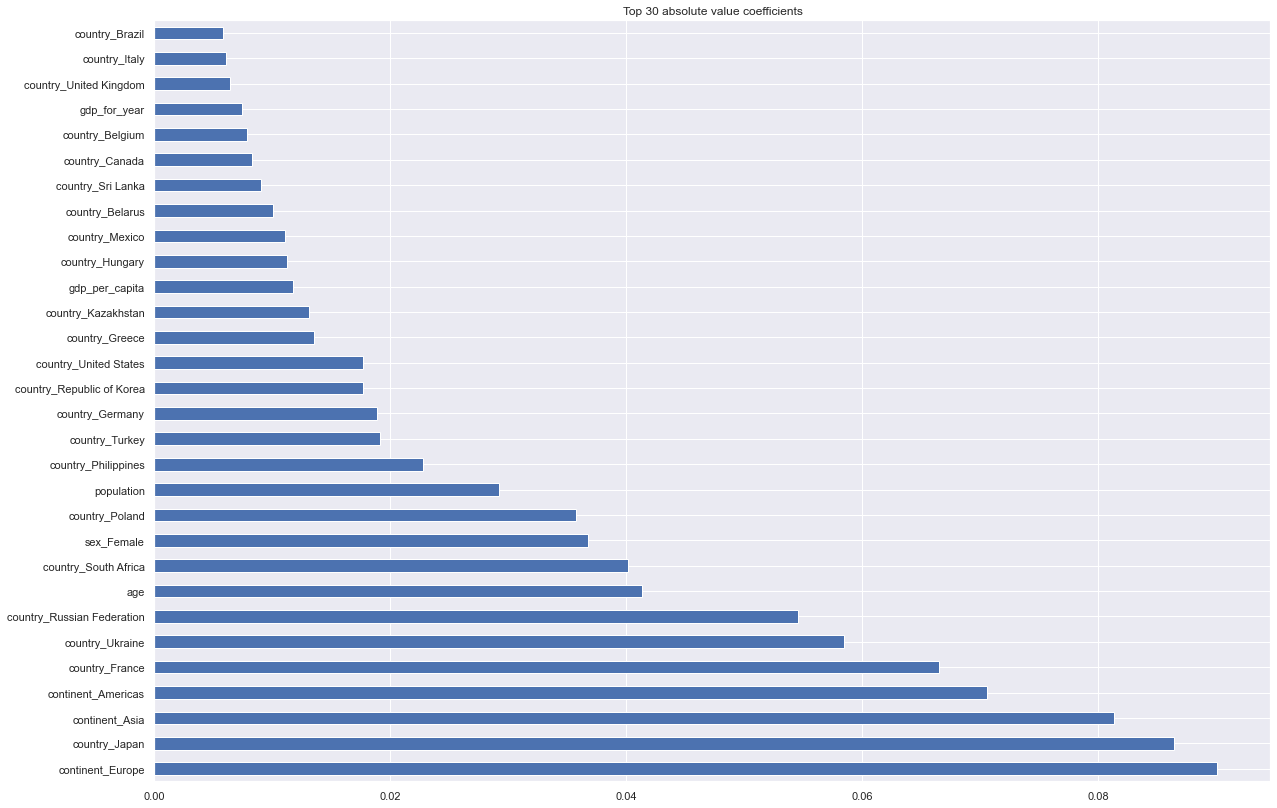

In [283]:
plot_top_feats(30, model.feature_importances_, features)

In [309]:
'''unfiltered data'''
model = XGBRegressor(n_estimators=750,
                      learning_rate=0.3,
                      max_depth=4,
                      subsample=0.6
                     )
model = train_model_cv(model, X_train_nf, y_train_nf, X_test_nf, y_test_nf)

mean 5 fold cross validated R^2 score: 0.9810172330731483
runtime of training without CV: 39.999950647354126 seconds
runtime of prediction: 0.1399986743927002 seconds
RMSE for the Extra trees model on the test set: 91.4338478941955
R^2 test: 0.9889911864928954


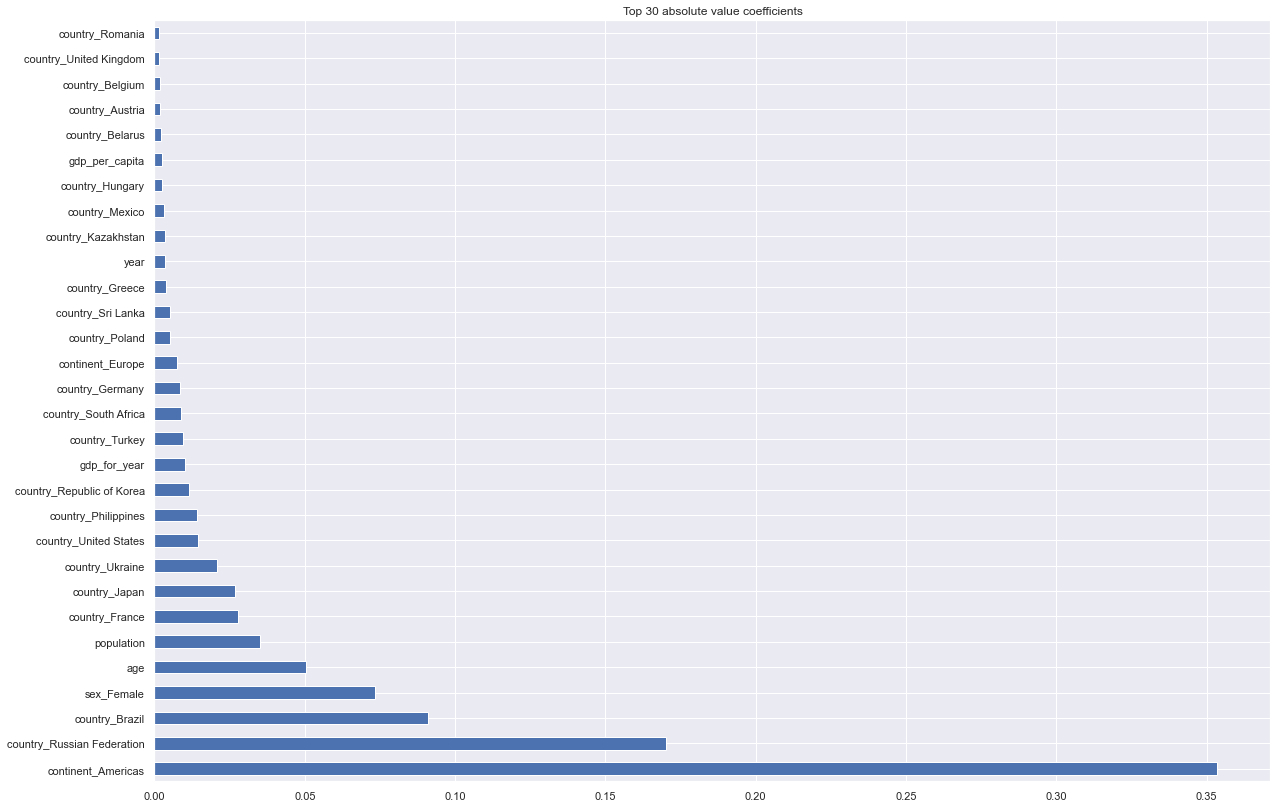

In [285]:
plot_top_feats(30, model.feature_importances_, features)

These weights do not show how the variable influences the regression but show the importance of each feature. Both the unfiltered and filtered version have a very very high R^2. The unfiltered data have a higher RMSE, due to the Russians having a high suicide number. In the feature importances, we can see how it correlates with what we've seen in EDA for the unfiltered version. There's a high influence for American countries and for Russia. It is interesing how the model with the unfiltered data achieves a better R^2 score on the test set. And as a pattern, the RMSE for the unfiltered data is higher, however close to some models trained on the filtered data.

# Conclusion
We would choose the XGBRegressor model as the model performs the best, getting to a R^2 score of and a RMSE of . The follow up would be the SVM regression with still very good results. In that model, one could remove the dimensionality by looking at the alpha values as the dual problem in the SVM optimization method puts certain alpha values to 0. 

# 4. Discussion of the results
We first learned how the data behaves, looks and such in the first part of our work. It was nice to be able to confirm my hypotheses on how certain variables influence peoples mental state. Next, we statistically proved 3 hypotheses concerning the suicide rate of certain groups. And lastly, we created an outstanding model for predicting the suicide number for certain groups. Having such a model and looking through the importances of the features enables us to directly see and attack the problems that influence the amount of people dying of their own will.

Although very interesting to me, as we keep hearing how mental health is being overloㅐked, I feel like there is not much of a use case of predicting suicide rate. It does give free information about certain groups mental state in points of their life but I do not seem to find anything else. Besides, of course, predicting the number of suicides and then focusing on those groups to prevent the people of commiting suicides. Instead of focusing on how many people commit suicide, I'd focus on explaining how our brain works as understanding our brain would provide a simpler way to preventing unnecessary deaths. I believe, we're at a point in science, where this is achievable.